# COMP 135 day 04: Linear Regression with Polynomial Features and Hyperparameter Selection on a fixed validation set

# Objectives

* Learn how to compute polynomial features
* Try out selecting the polynomial degree on a fixed validation set

* Learn how to use sklearn's built-in Polynomial feature transformer
* Learn how to use sklearn pipelines to compose useful elementary transformations and predictors


# Outline

* [Part 1: Linear Regression on Sine Wave dataset](#part1)
* [Part 2: Trying Polynomial Features + Linear Regression by hand](#part2)
* [Part 3: Selecting degree on Fixed Validation Set](#part3)
* [Part 4: Polynomial Feature transformer](#part4)
* [Part 5: Pipelines](#part5)


# Takeaways

* Hyperparameter selection is important to avoid overfitting (and underfitting)
* We cannot use the training set alone to select hyperparameters
* We should use a separate validation set to compute the error we use to select hyperparameters (or do cross-validation)
* Sklearn has many built-in features (Pipelines, feature transformers, etc) that make your life easier if you know how to use them well
* * They all follow a standard interface (aka "API")

In [1]:
import numpy as np

# Import the pandas (data management library)
import pandas as pd

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [3]:
import sklearn.linear_model
import sklearn.pipeline

# Prepare a simple 'sine-wave' dataset

In [4]:
SEED = 12345
prng = np.random.RandomState(SEED)

In [5]:
def true_prediction_function(x):
    return np.sin(2.1 * x)

In [6]:
N = 9        # num training examples (to estimate weight parameters)

x_N = np.linspace(-3, 3, N) + 0.09 * prng.randn(N)
print(x_N)
y_N = true_prediction_function(x_N) + 0.06 * prng.randn(N)
print(y_N)

[-3.01842369 -2.2068951  -1.54674948 -0.80001573  0.17692025  0.87540652
  1.50836171  2.27535715  3.06921203]
[ 0.01931014  1.05739797  0.02860633 -0.9775401   0.3767786   1.04559456
  0.02722174 -1.11793018  0.13913965]


In [7]:
L = 15      # num validation examples (to select hyperparameters)

x_va_L = np.linspace(-3.1, 3.1, L)
y_va_L = true_prediction_function(x_va_L) + 0.06 * prng.randn(L)

In [8]:
M = 500      # num testing examples (to show "true" generalization)

x_te_M = np.linspace(-3.5, 3.5, M)
y_te_M = true_prediction_function(x_te_M) + 0.06 * prng.randn(M)

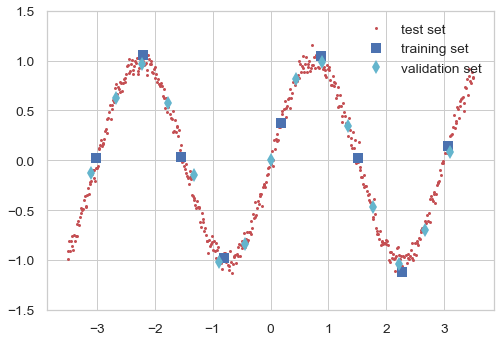

In [9]:
plt.plot(x_te_M, y_te_M, 'r.', label='test set')
plt.plot(x_N, y_N, 'bs', markersize=10, label='training set')
plt.plot(x_va_L, y_va_L, 'cd', markersize=10, label='validation set')

plt.legend(loc='upper right');
plt.ylim([-1.5, 1.5]);

<a id="part1"></a>

# Part 1: Linear Regression

First, let's try to fit plain old linear regression to this dataset.

In [10]:
lin_regr = sklearn.linear_model.LinearRegression()

### Exercise 1: Can you fit a linear regression and see what its predictions look like?

In [25]:
x_N1 = np.reshape(x_N, (N, 1))
lin_regr.fit(x_N1, y_N) # TODO fix me. Read error message below. Why does this break?

LinearRegression()

### Exercise 1b: Can you make predictions using the model above on the heldout test set?

In [26]:
x_te_M1 = np.reshape(x_te_M, (M, 1))
yhat_te_M = lin_regr.predict(x_te_M) # TODO something like "lin_regr.predict(x_te_M)""

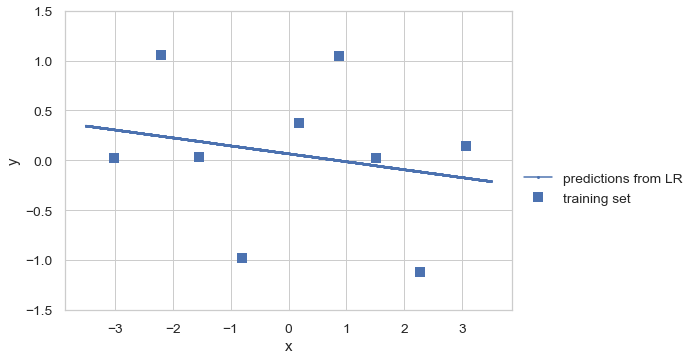

In [27]:
plt.plot(x_te_M, yhat_te_M, 'b.-', label='predictions from LR')
plt.plot(x_N, y_N, 'bs', markersize=10, label='training set')

plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.ylim([-1.5, 1.5]);
plt.xlabel('x');
plt.ylabel('y');

# Part 2: Polynomial Features

Given our scalar feature $x_i \in \mathbb{R}$, we want to TRANSFORM it to a $F$-degree polynomial feature vector (of size $F+1$)

$$
\begin{align}
\phi_0(x_i) &= [1]
\\
\phi_1(x_i) &= [1 ~~ x_i]
\\
\phi_2(x_i) &= [1 ~~ x_i ~~ x_i^2]
\\
\phi_3(x_i) &= [1 ~~ x_i ~~ x_i^2 ~~ x_i^3] \\
\vdots \\
\phi_F(x_i) &= [1 ~~ x_i ~~ x_i^2 ~~ x_i^3 ~~ \ldots x_i^F]
\end{align}
$$

And then use these transformed features to do linear regression.

That is, we'll learn weights for each of the entries of the vector produced by $\phi_F$

### Exercise 2a: FIX this function so it returns a polynomial feature expansion like above

In [65]:
def make_poly_features(x_N1, degree=0):
    ''' Transform some 1-dim feature array into polynomial features
    
    Args
    ----
    x_N1 : 2D array, shape (N, 1)
        Input features of a 1d regression problem
    degree : int
        Indicates degree of polynomial
    
    Returns
    -------
    phi_NG : 2D array, shape (N, G)
        where G = degree + 1
    '''
    assert x_N1.ndim == 2
    N, _ = x_N1.shape
    
    if degree == 0:
        phi_NG = np.ones((N, 1))
    elif degree >= 1:
        # stack together horizontally a column of all ones and the x array
        phi_NG = np.hstack(
            [np.ones((N, 1))]
            + [x_N1.copy() ** (d + 1) for d in range(degree)] 
            )
    return phi_NG

Create an array to try things out as input

In [66]:
my_x_N1 = np.asarray([[0.], [1], [2], [3]])
print(my_x_N1)

[[0.]
 [1.]
 [2.]
 [3.]]


In [67]:
make_poly_features(my_x_N1, degree = 0)

array([[1.],
       [1.],
       [1.],
       [1.]])

In [68]:
make_poly_features(my_x_N1, degree = 1)

array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.]])

In [69]:
make_poly_features(my_x_N1, degree = 2)

array([[1., 0., 0.],
       [1., 1., 1.],
       [1., 2., 4.],
       [1., 3., 9.]])

In [70]:
make_poly_features(my_x_N1, degree = 4)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  4.,  8., 16.],
       [ 1.,  3.,  9., 27., 81.]])

# Part 3: Hyperparameter Selection for Linear Regression with Poly. Features





In [ ]:
x_N1 = np.reshape(x_N, (N, 1))
x_va_L1 = np.reshape(x_va_L, (L, 1))
x_te_M1 = np.reshape(x_te_M, (M, 1))

### Exercise 3a: Edit code below to properly do the polynomial feature transformation (use your function above)

In [ ]:
fig_h, ax_grid = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,6))

for ii, degree in enumerate([1, 2, 3, 4, 5, 6, 7, 8]):
    cur_ax = ax_grid.reshape((8,))[ii]

    lin_regr = sklearn.linear_model.LinearRegression()
    
    phi_NG = x_N1       # TODO fix to transform x with your function above!
    phi_va_LG = x_va_L1 # TODO fix to transform validation features
    phi_te_MG = x_te_M1 # TODO fix to transform test features

    # Train the model
    lin_regr.fit(phi_NG, y_N)

    # Make predictions
    yhat_N = lin_regr.predict(phi_NG)
    yhat_va_L = lin_regr.predict(phi_va_LG)
    yhat_te_M = lin_regr.predict(phi_te_MG)
    
    # Evaluate the ERROR on training set and test set
    tr_err = sklearn.metrics.mean_squared_error(y_N, yhat_N)
    va_err = sklearn.metrics.mean_squared_error(y_va_L, yhat_va_L)
    te_err = sklearn.metrics.mean_squared_error(y_te_M, yhat_te_M)
    
    print("degree %d | train error %10.3f | valid error %10.3f | test error %10.3f" % (
        degree, tr_err, va_err, te_err))
    
    # Plot the predictions on current axis
    cur_ax.plot(x_te_M1, yhat_te_M, 'b-');
    cur_ax.plot(x_N, y_N, 'bs');
    
    cur_ax.set_title('degree %d' % degree)

### Exercise 3b: Which degree offers the lowest error on the validation dataset?

In [ ]:
# TODO fill

### Exercise 3c: Which degree offers the lowest error on the test dataset?

WARNING: if you really used this to pick your degree you could not later use the test set to fairly report your model's ability to generalize. Once you use the test set to train or select, you can't reuse it.

In [ ]:
# TODO fill

# Part 4: Using sklearn's built in Polynomial feature transform

You can read up here:

<https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features>

Or dive in! 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

my_x_N1 = np.arange(3).reshape(3, 1)
print("Original Features my_x_N1")
print(my_x_N1)

In [ ]:
poly = PolynomialFeatures(2)
phi_NG = poly.fit_transform(my_x_N1) # call 'fit_transform' to perform the transformation

print("Transformed Features phi_NG using 2-degree polynomial")
print(phi_NG)

In [ ]:
poly = PolynomialFeatures(5)
phi_NG = poly.fit_transform(my_x_N1)

print("Transformed Features phi_NG using 5-degree polynomial")
print(phi_NG)

Now try with more than one feature (e.g. each x vector is 2-dim.)

In [ ]:
my_x_N2 = np.asarray([[0, 3], [1, 4], [2, 5]])
print("Original Features my_x_N2")
print(my_x_N2)

In [ ]:
poly = PolynomialFeatures(1)
phi_NG = poly.fit_transform(my_x_N2)

print("Transformed Features phi_NG using 1-degree polynomial")
print(phi_NG)

In [ ]:
poly = PolynomialFeatures(2)
phi_NG = poly.fit_transform(my_x_N2)

print("Transformed Features phi_NG using 2-degree polynomial")
print(phi_NG)

Conveniently, we can ask the feature transformer how it came up with these features

In [ ]:
poly.get_feature_names(['a', 'b'])

Now try 3-rd degree

In [ ]:
poly = PolynomialFeatures(3)
phi_NG = poly.fit_transform(my_x_N2)

print("Transformed Features phi_NG using 3-degree polynomial")
print(phi_NG)

In [ ]:
poly.get_feature_names(['a', 'b'])

# Part 5: Using sklearn's built in Pipeline system

Often, we want to compose together some feature transformations and some predictor (like Linear Regression)

Sklearn lets us do that easily with a Pipeline

Read up here: 

<https://scikit-learn.org/stable/modules/compose.html#pipeline>

The key advantages of pipelines here are 

**Convenience** 

A pipeline is one object that handles everything

* every time we call fit, we first transform the raw features "x" into the transformed ones "phi", and then we do linear regression fitting using those transformed features
* every time we call predict, we first transform the raw features "x" into the transformed ones "phi", and then use linear regression to predict

Otherwise, we'd have to call `make_poly_features' so many times.

**Correctness**

Pipelines help us avoid having data leaks (e.g. have test data impact the transformation we learn). More about this later in the course.

To construct a pipeline, we just provide a list of steps.

Each STEP is just a tuple:
* first entry is the string name of the step (can be anything you want)
* second entry is the constructed sklearn estimator that will implement that step

In [ ]:
pipeline = sklearn.pipeline.Pipeline([
    ("step1", sklearn.preprocessing.PolynomialFeatures()),
    ("step2", sklearn.linear_model.LinearRegression()),
    ])

In [ ]:
pipeline

Now, we can use a pipeline like so:

In [ ]:
fig_h, ax_grid = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(20,9))

for ii, degree in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):

    cur_ax = ax_grid.reshape((12,))[ii]
    
    pipeline = sklearn.pipeline.Pipeline([
        ("step1", sklearn.preprocessing.PolynomialFeatures(degree)), # create custom Poly featurizer
        ("step2", sklearn.linear_model.LinearRegression()),
        ])

    # Train the model
    pipeline.fit(x_N1, y_N)                # Can use raw x here, unlike above

    # Make predictions
    yhat_N = pipeline.predict(x_N1)        # Can use raw x here too!
    yhat_va_L = pipeline.predict(x_va_L1)
    yhat_te_M = pipeline.predict(x_te_M1)
    
    # Evaluate the ERROR on training set and test set
    tr_err = sklearn.metrics.mean_squared_error(y_N, yhat_N)
    va_err = sklearn.metrics.mean_squared_error(y_va_L, yhat_va_L)
    te_err = sklearn.metrics.mean_squared_error(y_te_M, yhat_te_M)
    
    print("degree %3d | train error % 10.3f | valid error %10.3f | test error % 10.3f" % (
        degree, tr_err, va_err, te_err))
    
    # Plot the predictions
    cur_ax.plot(x_te_M1, y_te_M, 'r.');
    cur_ax.plot(x_te_M1, yhat_te_M, 'b-');
    cur_ax.plot(x_N, y_N, 'bs');
    cur_ax.set_title('degree %d' % degree);
    cur_ax.set_ylim([-2, 2]);

### Exercise 5a: Which degree offers would you select based on the validation set?

### Discussion 5b: What do you notice about the error INSIDE the bounds of observed training data versus OUTSIDE the bounds?